In [3]:
# reads the config file to get valid classes

valid_classes = set()
with open("valid_classes.txt", "r") as fp:
    for line in fp:
        valid_classes.add(line.strip())
print(valid_classes)
print(len(valid_classes))

{'regulatory--no-parking--g2', 'regulatory--maximum-speed-limit-55--g2', 'warning--road-narrows-left--g2', 'regulatory--maximum-speed-limit-25--g2', 'warning--pedestrians-crossing--g4', 'warning--roundabout--g2', 'regulatory--keep-left--g2', 'regulatory--do-not-block-intersection--g1', 'regulatory--turn-left--g2', 'regulatory--stop--g1', 'warning--steep-descent--g2', 'complementary--obstacle-delineator--g1', 'regulatory--one-way-right--g3', 'warning--narrow-bridge--g1', 'warning--turn-right--g1', 'warning--t-roads--g2', 'regulatory--wrong-way--g1', 'warning--crossroads--g3', 'regulatory--maximum-speed-limit-30--g3', 'information--disabled-persons--g1', 'regulatory--go-straight--g3', 'regulatory--yield--g1', 'information--gas-station--g1', 'regulatory--no-heavy-goods-vehicles--g2', 'complementary--chevron-right--g1', 'regulatory--no-entry--g1', 'information--highway-exit--g1', 'complementary--tow-away-zone--g1', 'warning--traffic-merges-right--g1', 'regulatory--no-overtaking--g5', 'warn

In [5]:
# Verify aspects of the our classes and gets list of valid images
import shutil
import os
import glob
import json

annotations_path = "mtsd_fully_annotated/annotations"
images_path = "mtsd_fully_annotated/images"

problem_image_count = 0 # Number of images that we shouldn't include
all_missing_classes = set() # Number of classes that are missing which caused the problem images
total_valid = 0 # Total number of valid images
seen_valid = set() # Classes that we have seen in the valid images

valid_images = set() # Images that are valid and we can include

for annotation in glob.glob(os.path.join(annotations_path, "*.json")):
    with open(annotation, "r") as fp:
        data = json.loads(fp.read())
    at_least_one = False
    not_included = set()
    contained_classes = set()
    
    for obj in data["objects"]:
        # Dont recognize the label and its not "other-sign"
        if obj["label"] not in valid_classes and obj["label"] != "other-sign":
            not_included.add(obj["label"])
        # Recognized the label and/or its "other-sign"
        else:
            contained_classes.add(obj["label"])
            at_least_one = True
    
    # If there is at least one that is valid, but there are other invalid classes
    if at_least_one and not_included:
        problem_image_count += 1
        all_missing_classes = all_missing_classes.union(not_included)
#         print("The image '{}' is missing: '{}'".format(annotation, not_included))
    # All the classes are valid
    elif at_least_one:
        valid_images.add(annotation)
        seen_valid = seen_valid.union(contained_classes)
        total_valid += 1

print(problem_image_count)
print(total_valid)
print(len(all_missing_classes))
print(len(valid_classes.difference(seen_valid)))
print(valid_classes.difference(seen_valid))
print(seen_valid.difference(valid_classes))
print(len(valid_images))


19685
19041
238
0
set()
{'other-sign'}
19041


In [ ]:
from PIL import Image
images_path = "mtsd_fully_annotated/images"

def get_pil_box(bbox):
    return (bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"])

for annotation_name in valid_images:
    name = os.path.splitext(os.path.basename(annotation_name))[0]
    with open(annotation_name, "r") as fp:
        data = json.loads(fp.read())
        
    imagefile = os.path.join(images_path, "%s.jpg" % name)
#     if os.path.isfile(imagefile):
#         print("%s does not have .jpg" % annotation_name)
#         continue
#     print(imagefile)
    for obj in data["objects"]:
        if obj["label"] == "other-sign":
            key = obj["key"]
            try:
                img = Image.open(imagefile)
                crop = img.crop(get_pil_box(obj["bbox"]))
                crop.save(os.path.join("new_dataset/other-sign", key + ".jpg"))
            except Exception:
                print("%s does not have jpg" % imagefile)

In [9]:
invalid_images = set()
for annotation_name in valid_images:
    name = os.path.splitext(os.path.basename(annotation_name))[0]
    imagefile = os.path.join(images_path, "%s.jpg" % name)
    with open(annotation_name, "r") as fp:
        data = json.loads(fp.read())
    classes = set([x["label"] for x in data["objects"]])
    if len(classes) == 1 and "other-sign" in classes:
        invalid_images.add(annotation_name)
        
print(len(valid_images.difference(invalid_images)))
print(len(invalid_images.difference(valid_images)))

        
print(len(valid_images))
print(invalid_count)
print(len(valid_images) - invalid_count)

for annotation_name in valid_images.difference(invalid_images):
    name = os.path.splitext(os.path.basename(annotation_name))[0]
    imagefile = os.path.join(images_path, "%s.jpg" % name)
    shutil.copy(annotation_name, "new_raw_dataset/annotations/%s.json" % name)
    shutil.copy(imagefile, "new_raw_dataset/images/%s.jpg" % name)

6467
0
19041
12574
6467


In [31]:
images_path = "cropped"
new_path = "new_dataset"

copied_classes = set()
for class_folder in glob.glob(os.path.join(images_path, "*/*--*")):
    class_name = class_folder.split("/")[-1]
    if class_name in valid_classes:
        copied_classes.add(class_name)
        shutil.copytree(class_folder, os.path.join(new_path, class_name))
        
print(valid_classes.difference(copied_classes))
print(copied_classes.difference(valid_classes))

AttributeError: 'set' object has no attribute 'different'

In [32]:
print(valid_classes.difference(copied_classes))
print(copied_classes.difference(valid_classes))

set()
set()


new_dataset/regulatory--yield--g1 2775
new_dataset/warning--t-roads--g2 46


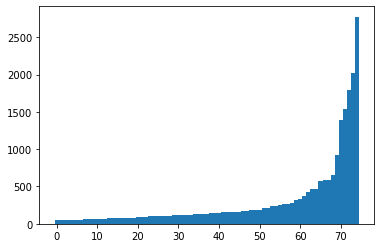

In [38]:
import matplotlib.pyplot as plt
class_counts = {}
for class_folder in glob.glob(os.path.join("new_dataset", "*--*")):
    class_counts[class_folder] = len(os.listdir(class_folder))
    
max_class = max(class_counts, key=class_counts.get)
min_class = min(class_counts, key=class_counts.get)

plt.bar(range(len(class_counts)), sorted(class_counts.values()), 1)
print("{} {}".format(max_class, class_counts[max_class]))
print("{} {}".format(min_class, class_counts[min_class]))